In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(),
    transforms.RandomApply([transforms.GaussianBlur(5)], p=0.5),
    transforms.RandomAffine(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# Load the dataset
dataset = ImageFolder(root='frames', transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 16 * 16, 32)  
        self.fc2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 16 * 16)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = SimpleCNN()


In [5]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
num_epochs = 20
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.float().view(-1, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            labels = labels.float().view(-1, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.2f}%")


  5%|▌         | 1/20 [01:06<21:02, 66.47s/it]

Epoch 1/20, Train Loss: 0.3259, Train Acc: 87.54%, Test Loss: 0.2670, Test Acc: 88.65%


 10%|█         | 2/20 [02:06<18:44, 62.47s/it]

Epoch 2/20, Train Loss: 0.1666, Train Acc: 93.21%, Test Loss: 0.0926, Test Acc: 98.85%


 15%|█▌        | 3/20 [03:04<17:11, 60.68s/it]

Epoch 3/20, Train Loss: 0.0881, Train Acc: 98.44%, Test Loss: 0.0815, Test Acc: 98.85%


 20%|██        | 4/20 [04:02<15:50, 59.39s/it]

Epoch 4/20, Train Loss: 0.0763, Train Acc: 99.38%, Test Loss: 0.0717, Test Acc: 99.67%


 25%|██▌       | 5/20 [04:58<14:36, 58.42s/it]

Epoch 5/20, Train Loss: 0.0710, Train Acc: 99.63%, Test Loss: 0.0692, Test Acc: 99.84%


 30%|███       | 6/20 [05:55<13:29, 57.80s/it]

Epoch 6/20, Train Loss: 0.0677, Train Acc: 99.55%, Test Loss: 0.0649, Test Acc: 99.84%


 35%|███▌      | 7/20 [06:51<12:26, 57.41s/it]

Epoch 7/20, Train Loss: 0.0669, Train Acc: 99.42%, Test Loss: 0.0633, Test Acc: 99.67%


 40%|████      | 8/20 [07:48<11:25, 57.15s/it]

Epoch 8/20, Train Loss: 0.0616, Train Acc: 99.75%, Test Loss: 0.0586, Test Acc: 100.00%


 45%|████▌     | 9/20 [08:45<10:27, 57.04s/it]

Epoch 9/20, Train Loss: 0.0581, Train Acc: 99.84%, Test Loss: 0.0557, Test Acc: 100.00%


 50%|█████     | 10/20 [09:42<09:29, 56.94s/it]

Epoch 10/20, Train Loss: 0.0552, Train Acc: 99.92%, Test Loss: 0.0528, Test Acc: 100.00%


 55%|█████▌    | 11/20 [10:39<08:32, 56.93s/it]

Epoch 11/20, Train Loss: 0.0525, Train Acc: 99.92%, Test Loss: 0.0502, Test Acc: 100.00%


 60%|██████    | 12/20 [11:35<07:34, 56.85s/it]

Epoch 12/20, Train Loss: 0.0501, Train Acc: 99.92%, Test Loss: 0.0486, Test Acc: 100.00%


 65%|██████▌   | 13/20 [12:32<06:37, 56.82s/it]

Epoch 13/20, Train Loss: 0.0477, Train Acc: 99.92%, Test Loss: 0.0469, Test Acc: 100.00%


 70%|███████   | 14/20 [13:29<05:40, 56.80s/it]

Epoch 14/20, Train Loss: 0.0462, Train Acc: 99.92%, Test Loss: 0.0443, Test Acc: 100.00%


 75%|███████▌  | 15/20 [14:25<04:43, 56.80s/it]

Epoch 15/20, Train Loss: 0.0437, Train Acc: 99.92%, Test Loss: 0.0422, Test Acc: 100.00%


 80%|████████  | 16/20 [15:22<03:47, 56.78s/it]

Epoch 16/20, Train Loss: 0.0421, Train Acc: 99.92%, Test Loss: 0.0401, Test Acc: 100.00%


 85%|████████▌ | 17/20 [16:19<02:50, 56.80s/it]

Epoch 17/20, Train Loss: 0.0401, Train Acc: 99.92%, Test Loss: 0.0390, Test Acc: 100.00%


 90%|█████████ | 18/20 [17:16<01:53, 56.83s/it]

Epoch 18/20, Train Loss: 0.0389, Train Acc: 99.88%, Test Loss: 0.0368, Test Acc: 100.00%


 95%|█████████▌| 19/20 [18:13<00:56, 56.84s/it]

Epoch 19/20, Train Loss: 0.0370, Train Acc: 99.92%, Test Loss: 0.0353, Test Acc: 100.00%


100%|██████████| 20/20 [19:14<00:00, 57.71s/it]

Epoch 20/20, Train Loss: 0.0354, Train Acc: 99.92%, Test Loss: 0.0338, Test Acc: 100.00%


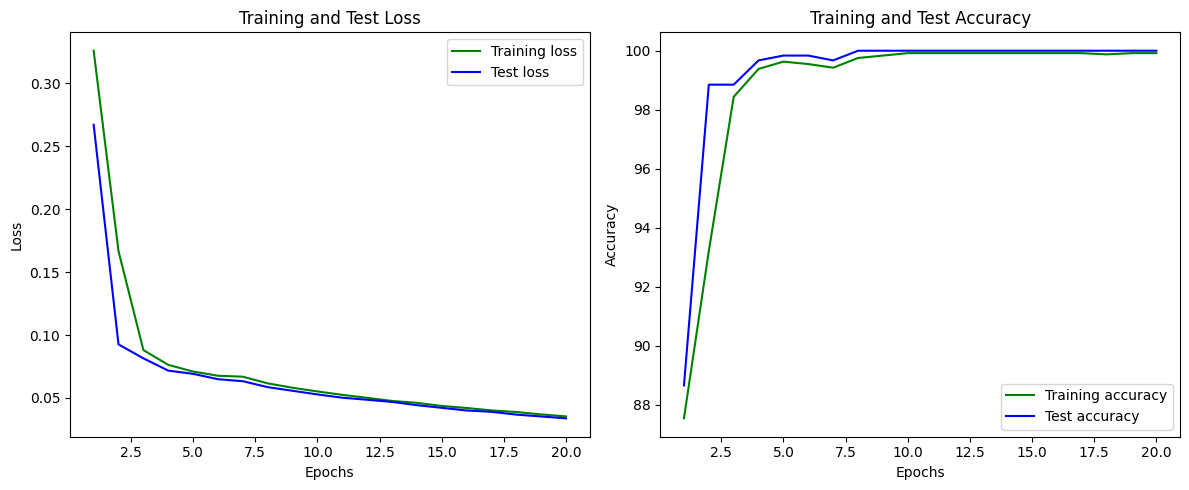

In [7]:
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, test_losses, 'b', label='Test loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
model_path = 'cnn.pth'
torch.save(model.state_dict(), model_path)